In [139]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import classification_report, \
                            confusion_matrix, \
                            ConfusionMatrixDisplay

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import datasets, layers, models, losses
from tensorflow.keras.models import Model

In [162]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [140]:
seed_number = 10
tf.random.set_seed(seed_number)
np.random.seed(seed_number)

import warnings
warnings.filterwarnings('ignore')

In [150]:
def plot_nn_history(history, figsize=(8,4)):
    fig, ax = plt.subplots(1,2, figsize=figsize)

    for i, field in enumerate(['acc', 'loss']):
        ax[i].plot(history.history[field])
        ax[i].plot(history.history[f'val_{field}'])
        ax[i].set_title(f'model {field}')
        ax[i].set_ylabel(field)
        ax[i].set_xlabel('epoch')
        ax[i].legend(['train', 'val'], loc='upper left')
    
    plt.tight_layout()
    plt.show()

# **TRAIN-TEST SPLIT**

In [141]:
DATASET_NAME = 'simpsons-small-balanced-tf'

batch_size_ = 32
input_shape_ = (315, 390, 3)
class_names = ['bart', 'homer', 'lisa', 'maggie', 'marge']
num_classes = len(class_names)

In [142]:
X_train, X_val = tf.keras.utils.image_dataset_from_directory(
    f'../data/{DATASET_NAME}/',
    seed=seed_number,
    subset='both',
    validation_split=.2,
    image_size=(input_shape_[0], input_shape_[1]),
    batch_size=batch_size_
)

Found 419 files belonging to 5 classes.
Using 336 files for training.
Using 83 files for validation.


In [143]:
y_train = tf.concat([y for x, y in X_train], axis=0)
y_val = tf.concat([y for x, y in X_val], axis=0)

y_train.shape, y_val.shape

(TensorShape([336]), TensorShape([83]))

# **5-LAYER CNN**

In [146]:
model = models.Sequential()

model.add(layers.Rescaling(1./255, input_shape=input_shape_))

model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(num_classes,activation='softmax'))

model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_7 (Rescaling)     (None, 315, 390, 3)       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 313, 388, 32)      896       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 156, 194, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 154, 192, 64)      18496     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 77, 96, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 75, 94, 64)       

In [147]:
epochs_ = 20

model.compile(
    optimizer='Adam',
    loss='sparse_categorical_crossentropy',
    metrics=['acc']
)

history = model.fit(
    X_train,
    batch_size=batch_size_,
    epochs=epochs_,
    validation_data=X_val
)

Epoch 1/20
11/11 [==============================] - 44s 4s/step - loss: 17.9798 - acc: 0.3006 - val_loss: 1.5398 - val_acc: 0.2048
Epoch 2/20
11/11 [==============================] - 44s 4s/step - loss: 1.2567 - acc: 0.4077 - val_loss: 1.1538 - val_acc: 0.5783
Epoch 3/20
11/11 [==============================] - 43s 4s/step - loss: 0.8714 - acc: 0.6637 - val_loss: 1.2031 - val_acc: 0.5060
Epoch 4/20
11/11 [==============================] - 43s 4s/step - loss: 0.4650 - acc: 0.8274 - val_loss: 1.2256 - val_acc: 0.5663
Epoch 5/20
11/11 [==============================] - 43s 4s/step - loss: 0.2238 - acc: 0.9494 - val_loss: 1.2024 - val_acc: 0.5301
Epoch 6/20
11/11 [==============================] - 44s 4s/step - loss: 0.1186 - acc: 0.9673 - val_loss: 1.3965 - val_acc: 0.5904
Epoch 7/20
11/11 [==============================] - 44s 4s/step - loss: 0.0401 - acc: 0.9911 - val_loss: 1.7502 - val_acc: 0.5663
Epoch 8/20
11/11 [==============================] - 43s 4s/step - loss: 0.0153 - acc: 1.0

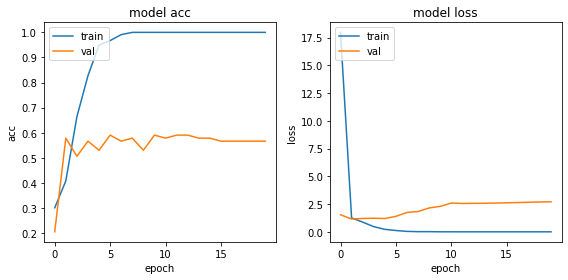

In [151]:
plot_nn_history(history)

evaluate = [2.710561990737915, 0.5662650465965271]
3/3 [==============================] - 3s 758ms/step
              precision    recall  f1-score   support

           0       0.57      0.73      0.64        22
           1       0.41      0.35      0.38        20
           2       0.55      0.65      0.59        17
           3       0.25      0.14      0.18         7
           4       0.86      0.71      0.77        17

    accuracy                           0.57        83
   macro avg       0.53      0.51      0.51        83
weighted avg       0.56      0.57      0.56        83



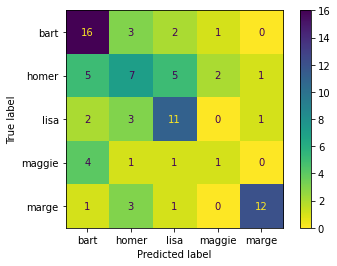

In [149]:
print('evaluate =', model.evaluate(X_val, verbose=0))

y_pred = model.predict(X_val)
y_pred = np.argmax(y_pred, axis=1)

print(classification_report(y_val, y_pred))

cm = confusion_matrix(y_val, y_pred)
cm_plot = ConfusionMatrixDisplay(cm, display_labels=class_names)
cm_plot.plot(cmap='viridis_r');

# **5-LAYER CNN COM DATA AUGMENTATION + DROPOUT**

O trecho abaixo realiza um *data augmentation* nas imagens originais, performando um `RandomFlip`, `RandomRotation` e `RandomZoom` nas imagens, sendo respectivamente um giro, rotação e aumento aleatórios. Essa técnica visa muitas vezes reduzir os efeitos do desbalanceamento, aumentando a quantidade das imagens. Outra diferença em relação à rede testada acima, se refere ao `Dropout`, camada da rede que elimina certos elementos, muitas vezes de maneira aleatória, visando contornar o *overfitting*. 

In [163]:
data_augmentation_layer = tf.keras.Sequential([
    layers.RandomFlip('horizontal', input_shape=input_shape_),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

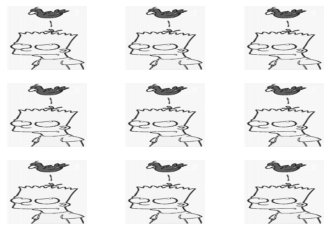

In [164]:
for images, _ in X_train.take(1):
    for i in range(9):
        augmented_images = data_augmentation_layer(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype('uint8'))
        plt.axis('off')

In [165]:
model = tf.keras.Sequential([
    data_augmentation_layer,  
    layers.Rescaling(1./255, input_shape=(96, 96, 3)),

    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),  
    layers.Dropout(0.2),
    layers.Flatten(),
    
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

In [155]:
model.compile(
    optimizer='Adam',
    loss='sparse_categorical_crossentropy',
    metrics=['acc']
)

history = model.fit(
    X_train,
    batch_size=batch_size_,
    epochs=epochs_,
    validation_data=X_val
)

Epoch 1/20
11/11 [==============================] - 58s 5s/step - loss: 5.4918 - acc: 0.2649 - val_loss: 1.4791 - val_acc: 0.4337
Epoch 2/20
11/11 [==============================] - 49s 4s/step - loss: 1.3499 - acc: 0.3988 - val_loss: 1.2057 - val_acc: 0.4337
Epoch 3/20
11/11 [==============================] - 48s 4s/step - loss: 1.0626 - acc: 0.5387 - val_loss: 1.1482 - val_acc: 0.5181
Epoch 4/20
11/11 [==============================] - 53s 5s/step - loss: 0.9586 - acc: 0.5774 - val_loss: 1.2129 - val_acc: 0.5663
Epoch 5/20
11/11 [==============================] - 51s 5s/step - loss: 0.9229 - acc: 0.5833 - val_loss: 1.2022 - val_acc: 0.5422
Epoch 6/20
11/11 [==============================] - 55s 5s/step - loss: 0.8772 - acc: 0.6042 - val_loss: 1.2679 - val_acc: 0.5783
Epoch 7/20
11/11 [==============================] - 55s 5s/step - loss: 0.7900 - acc: 0.6548 - val_loss: 1.0962 - val_acc: 0.6386
Epoch 8/20
11/11 [==============================] - 55s 5s/step - loss: 0.7806 - acc: 0.69

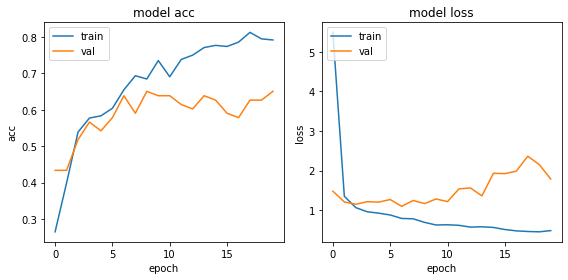

In [156]:
plot_nn_history(history)

evaluate = [1.786460280418396, 0.650602400302887]
3/3 [==============================] - 2s 682ms/step
              precision    recall  f1-score   support

           0       0.57      0.95      0.71        22
           1       0.64      0.35      0.45        20
           2       0.64      0.53      0.58        17
           3       0.60      0.43      0.50         7
           4       0.88      0.82      0.85        17

    accuracy                           0.65        83
   macro avg       0.66      0.62      0.62        83
weighted avg       0.67      0.65      0.63        83



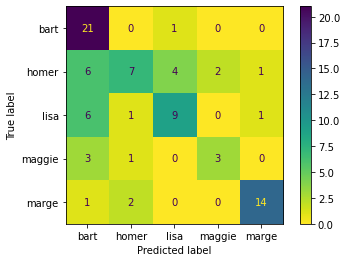

In [157]:
print('evaluate =', model.evaluate(X_val, verbose=0))

y_pred = model.predict(X_val)
y_pred = np.argmax(y_pred, axis=1)

print(classification_report(y_val, y_pred))

cm = confusion_matrix(y_val, y_pred)
cm_plot = ConfusionMatrixDisplay(cm, display_labels=class_names)
cm_plot.plot(cmap='viridis_r');

Observa-se, em relação à 5-Layer CNN anterior, um incremento em relação à acurácia global, bem como em relação às classes individualmente. Esse efeito já era esperado, considerando o *data augmentation* e o `Dropout`.

# **TRANSFER LEARNING COM** `ResNet50`

O trecho abaixo utiliza as camadas convolucionais da rede `ResNet50`, pré treinada, performando um *transfer learning*, de maneira que realizamos o treinamento somente nas camadas densas finais do nosso modelo. Essa técnica visa, grosseiramente falando, "transferir" o aprendizado obtido por outra rede que foi destinado a outra tarefa, para o nosso contexto. 

In [158]:
conv_layers =  tf.keras.applications.resnet50.ResNet50(
    weights=None,
    include_top=False,
    input_tensor=tf.keras.layers.Input(input_shape_),
    classes=num_classes
)

conv_layers.trainable = True

model = tf.keras.Sequential([  
  conv_layers,    
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 10, 13, 2048)      23587712  
                                                                 
 flatten_7 (Flatten)         (None, 266240)            0         
                                                                 
 dense_14 (Dense)            (None, 128)               34078848  
                                                                 
 dense_15 (Dense)            (None, 5)                 645       
                                                                 
Total params: 57,667,205
Trainable params: 57,614,085
Non-trainable params: 53,120
_________________________________________________________________


In [159]:
epochs_ = 10

model.compile(
    optimizer='Adam',
    loss='sparse_categorical_crossentropy',
    metrics=['acc']
)

history = model.fit(
    X_train,
    batch_size=batch_size_,
    epochs=epochs_,
    validation_data=X_val)

Epoch 1/10
11/11 [==============================] - 383s 32s/step - loss: 152.7440 - acc: 0.2619 - val_loss: 176413.6094 - val_acc: 0.2048
Epoch 2/10
11/11 [==============================] - 338s 30s/step - loss: 25.8551 - acc: 0.2619 - val_loss: 35119044.0000 - val_acc: 0.1687
Epoch 3/10
11/11 [==============================] - 304s 28s/step - loss: 4.1330 - acc: 0.2857 - val_loss: 1175828.8750 - val_acc: 0.2169
Epoch 4/10
11/11 [==============================] - 312s 28s/step - loss: 2.3980 - acc: 0.3304 - val_loss: 386.5735 - val_acc: 0.2410
Epoch 5/10
11/11 [==============================] - 303s 27s/step - loss: 1.6129 - acc: 0.3214 - val_loss: 36.9322 - val_acc: 0.2530
Epoch 6/10
11/11 [==============================] - 302s 27s/step - loss: 2.1271 - acc: 0.3095 - val_loss: 4.0420 - val_acc: 0.2530
Epoch 7/10
11/11 [==============================] - 307s 28s/step - loss: 1.5818 - acc: 0.3036 - val_loss: 4.3023 - val_acc: 0.2651
Epoch 8/10
11/11 [==============================] - 

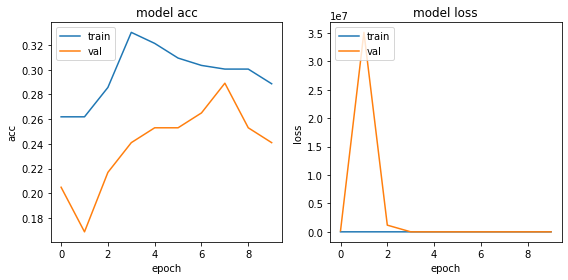

In [160]:
plot_nn_history(history)

In [ ]:
print('evaluate =', model.evaluate(X_val, verbose=0))

y_pred = model.predict(X_val)
y_pred = np.argmax(y_pred, axis=1)

print(classification_report(y_val, y_pred))

cm = confusion_matrix(y_val, y_pred)
cm_plot = ConfusionMatrixDisplay(cm, display_labels=class_names)
cm_plot.plot(cmap='viridis_r');